# Student Graduation Prediction
In this notebook, we will look at if combining the two targets; Enrolled and Graduate, could make the model predict more accurately.

The main goal of the model we are trying to make is to predict whether someone will drop out or not. Therefore, it is not that interesting finding out if a student is either enrolled or graduated, and perhaps the models could perform better when these targets are combined.

In [1]:
import catboost
import numpy as np
import pandas as pd

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_recall_curve, accuracy_score, classification_report, confusion_matrix, make_scorer, f1_score, roc_auc_score, roc_curve
from sklearn.inspection import permutation_importance
from sklearn.calibration import CalibratedClassifierCV

from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from catboost import CatBoostClassifier, Pool
from lightgbm import LGBMClassifier

import matplotlib.pyplot as plt
import shap

In [2]:
df = pd.read_csv('data/data.csv',sep=";")

target_map = {'Dropout': 1, 'Enrolled': 0, 'Graduate': 0}
y = df['Target'].map(target_map).astype(int).values
class_names = ['Not Dropped Out', 'Dropped Out']

X = df.drop(columns=['Target'])

In [3]:
class FeatureEngineer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        # ratios
        X["approval_ratio_1st"] = X["Curricular units 1st sem (approved)"] / X["Curricular units 1st sem (enrolled)"].replace(0, np.nan)
        X["approval_ratio_2nd"] = X["Curricular units 2nd sem (approved)"] / X["Curricular units 2nd sem (enrolled)"].replace(0, np.nan)
        # avg grade across semesters (ignore zeros)
        X["avg_grade"] = X[["Curricular units 1st sem (grade)", "Curricular units 2nd sem (grade)"]].replace(0, np.nan).mean(axis=1)
        # totals & overall ratio
        X["total_approved"] = X["Curricular units 1st sem (approved)"] + X["Curricular units 2nd sem (approved)"]
        X["total_enrolled"] = X["Curricular units 1st sem (enrolled)"] + X["Curricular units 2nd sem (enrolled)"]
        X["total_approval_ratio"] = X["total_approved"] / X["total_enrolled"].replace(0, np.nan)

        X["approval_diff"] = X["approval_ratio_2nd"] - X["approval_ratio_1st"]
        X["grade_diff"] = X["Curricular units 2nd sem (grade)"] - X["Curricular units 1st sem (grade)"]

        return X.fillna(0.0)

X = X.fillna(0)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [8]:
def printResults(name,y_test,y_pred,y_proba):
    print("\n=== " + name + " ===")
    print("Accuracy:", f"{accuracy_score(y_test, y_pred):.4f}")
    print("ROC-AUC:", f"{roc_auc_score(y_test, y_proba):.4f}")
    print(classification_report(y_test, y_pred, target_names=class_names))
    print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))

In [11]:
xgb = XGBClassifier(
    n_estimators=400,
    learning_rate=0.08,
    max_depth=6,
    subsample=0.9,
    colsample_bytree=0.9,
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=42,
    n_jobs=-1,
)

pipe_xgb = ImbPipeline([
    ("fe", FeatureEngineer()),
    ("clf", xgb),
])

pipe_xgb.fit(X_train, y_train)
y_pred = pipe_xgb.predict(X_test)

printResults("XGBoost", y_test, y_pred, pipe_xgb.predict_proba(X_test)[:, 1])


=== XGBoost ===
Accuracy: 0.8859
ROC-AUC: 0.9351
                 precision    recall  f1-score   support

Not Dropped Out       0.90      0.94      0.92       601
    Dropped Out       0.86      0.77      0.81       284

       accuracy                           0.89       885
      macro avg       0.88      0.86      0.87       885
   weighted avg       0.88      0.89      0.88       885

Confusion matrix:
 [[564  37]
 [ 64 220]]


In [12]:
pipe_xgb_smote = ImbPipeline([
    ("fe", FeatureEngineer()),
    ("smote", SMOTE(random_state=42)),
    ("clf", xgb),
])

pipe_xgb_smote.fit(X_train, y_train)
y_pred_sm = pipe_xgb_smote.predict(X_test)

printResults("XGBoost + SMOTE", y_test, y_pred_sm, pipe_xgb_smote.predict_proba(X_test)[:, 1])


=== XGBoost + SMOTE ===
Accuracy: 0.8893
ROC-AUC: 0.9352
                 precision    recall  f1-score   support

Not Dropped Out       0.91      0.93      0.92       601
    Dropped Out       0.84      0.80      0.82       284

       accuracy                           0.89       885
      macro avg       0.88      0.87      0.87       885
   weighted avg       0.89      0.89      0.89       885

Confusion matrix:
 [[559  42]
 [ 56 228]]


In [15]:
catboost_clf = CatBoostClassifier(
    iterations=500,
    learning_rate=0.05,
    depth=6,
    loss_function="Logloss",
    eval_metric="Accuracy",
    random_state=42,
    verbose=False
)

pipe_catboost = ImbPipeline([
    ("fe", FeatureEngineer()),
    ("smote", SMOTE(random_state=42)),
    ("clf", catboost_clf),
])

pipe_catboost.fit(X_train, y_train)

printResults("CatBoost + SMOTE", y_test, pipe_catboost.predict(X_test), pipe_catboost.predict_proba(X_test)[:, 1])


=== CatBoost + SMOTE ===
Accuracy: 0.8904
ROC-AUC: 0.9363
                 precision    recall  f1-score   support

Not Dropped Out       0.91      0.93      0.92       601
    Dropped Out       0.84      0.82      0.83       284

       accuracy                           0.89       885
      macro avg       0.88      0.87      0.87       885
   weighted avg       0.89      0.89      0.89       885

Confusion matrix:
 [[556  45]
 [ 52 232]]


In [14]:
lgbm_clf = LGBMClassifier(
    n_estimators=500,
    learning_rate=0.05,
    num_leaves=31,
    objective="binary",
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=42,
    n_jobs=-1,
)

pipe_lgbm = ImbPipeline([
    ("fe", FeatureEngineer()),
    ("smote", SMOTE(random_state=42)),
    ("clf", lgbm_clf),
])

pipe_lgbm.fit(X_train, y_train)

printResults("LightGBM + SMOTE", y_test, pipe_lgbm.predict(X_test), pipe_lgbm.predict_proba(X_test)[:, 1])

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 2402, number of negative: 2402
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000574 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3948
[LightGBM] [Info] Number of data points in the train set: 4804, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

=== LightGBM + SMOTE ===
Accuracy: 0.8836
ROC-AUC: 0.9320
                 precision    recall  f1-score   support

Not Dropped Out       0.91      0.92      0.91       601
    Dropped Out       0.82      0.81      0.82       284

       accuracy                           0.88       885
      macro avg       0.87      0.86      0.87       885
   weighted avg       0.88      0.88      0.88       885

Confusion matrix

### Learning from the Models
It is also important to look at what features makes the most impact on the model. Beneath, we will look at the top 10 most important features for the best performing model above: XGBoost (without SMOTE). We will also have a look at which features could be harmful and see if removing those features could improve accuracy.

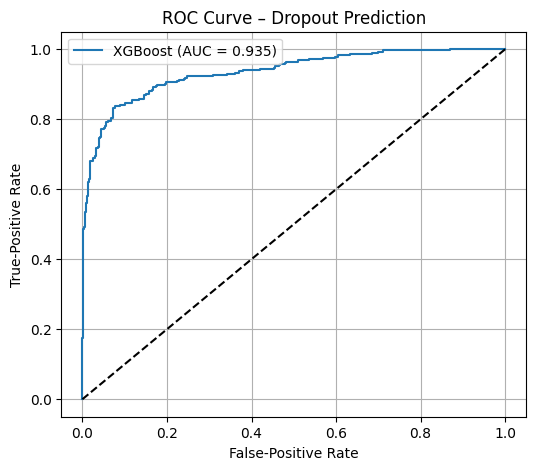

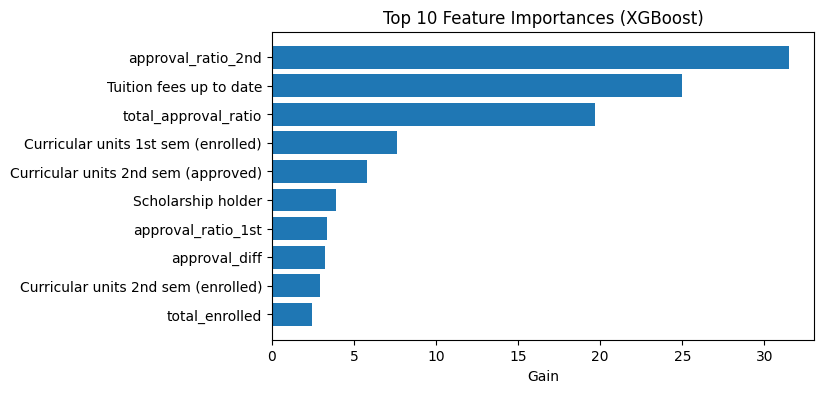

In [16]:
y_proba = pipe_xgb.predict_proba(X_test)[:, 1]

roc_auc = roc_auc_score(y_test, y_proba)

fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"XGBoost (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False-Positive Rate")
plt.ylabel("True-Positive Rate")
plt.title("ROC Curve – Dropout Prediction")
plt.legend()
plt.grid(True)
plt.show()

booster = pipe_xgb.named_steps["clf"].get_booster()
importance = booster.get_score(importance_type="gain")
importance_df = (
    pd.DataFrame(list(importance.items()), columns=["Feature", "Gain"])
    .sort_values("Gain", ascending=False)
    .head(10)
)
plt.figure(figsize=(7, 4))
plt.barh(importance_df["Feature"], importance_df["Gain"])
plt.gca().invert_yaxis()
plt.title("Top 10 Feature Importances (XGBoost)")
plt.xlabel("Gain")
plt.show()

🔻 Features potentially hurting the model (lowest permutation importance):
                                           Feature  Importance_Mean  \
7                                      Nationality        -0.000719   
15                                          Debtor        -0.000340   
6                   Previous qualification (grade)        -0.000231   
0                                   Marital status        -0.000161   
4                     Daytime/evening attendance\t        -0.000008   
14                       Educational special needs         0.000029   
20                                   International         0.000042   
1                                 Application mode         0.000066   
32  Curricular units 2nd sem (without evaluations)         0.000076   
26  Curricular units 1st sem (without evaluations)         0.000077   

    Importance_Std  
7         0.000339  
15        0.000990  
6         0.001260  
0         0.000254  
4         0.000025  
14        0.000023

C:\Users\willi\AppData\Local\Temp\ipykernel_32196\1072466745.py:21: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  plt.tight_layout()
D:\PycharmProjects\tdt4259\.venvv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


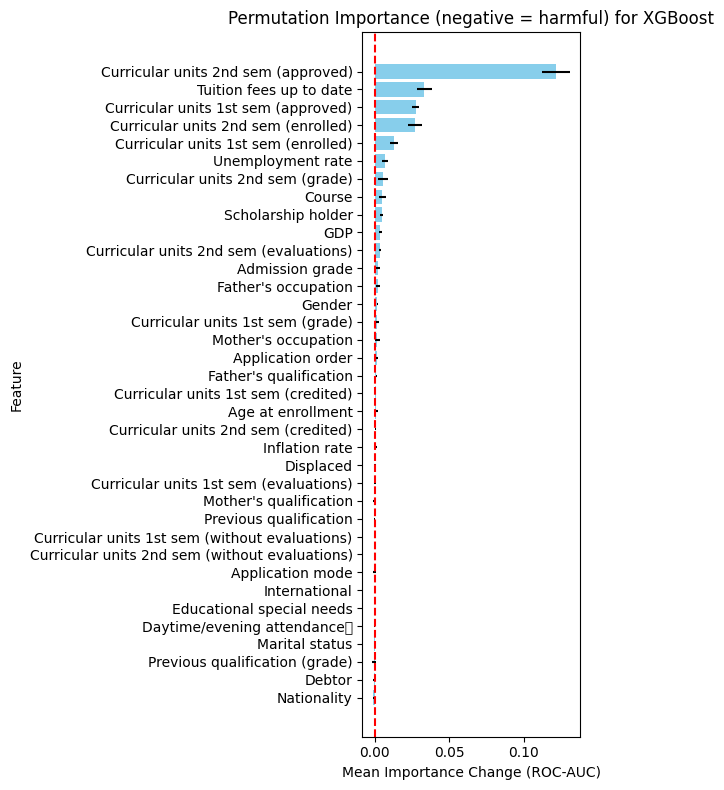

In [23]:
r = permutation_importance(
    pipe_xgb, X_test, y_test,
    scoring="roc_auc", n_repeats=5, random_state=42, n_jobs=-1
)

imp_df = pd.DataFrame({
    "Feature": X_test.columns,
    "Importance_Mean": r.importances_mean,
    "Importance_Std": r.importances_std
}).sort_values("Importance_Mean", ascending=True)

print("🔻 Features potentially hurting the model (lowest permutation importance):")
print(imp_df.head(10))

plt.figure(figsize=(6, 8))
plt.barh(imp_df["Feature"], imp_df["Importance_Mean"], xerr=imp_df["Importance_Std"], color="skyblue")
plt.axvline(0, color="red", linestyle="--")
plt.title("Permutation Importance (negative = harmful) for XGBoost")
plt.xlabel("Mean Importance Change (ROC-AUC)")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

In [25]:
harmful_features = [
    "Mother's qualification",
    "Application mode",
    "Previous qualification",
    "Curricular units 2nd sem (without evaluations)",
    "Marital status",
    "Nationality",
    "Inflation rate",
    "Daytime/evening attendance\t",
    "International",
    "Educational special needs",
]

X_cleaned = X.drop(columns=harmful_features, errors="ignore")

X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
    X_cleaned, y, stratify=y, test_size=0.2, random_state=42
)

pipe_catboost_clean = ImbPipeline([
    ("fe", FeatureEngineer()),
    ("clf", catboost_clf),
])

pipe_catboost_clean.fit(X_train_c, y_train_c)

printResults("XGBoost (Cleaned Feature Set)", y_test_c, pipe_catboost_clean.predict(X_test_c), pipe_catboost_clean.predict_proba(X_test)[:, 1])


=== XGBoost (Cleaned Feature Set) ===
Accuracy: 0.8859
ROC-AUC: 0.9383
                 precision    recall  f1-score   support

Not Dropped Out       0.90      0.94      0.92       601
    Dropped Out       0.85      0.78      0.81       284

       accuracy                           0.89       885
      macro avg       0.88      0.86      0.87       885
   weighted avg       0.88      0.89      0.88       885

Confusion matrix:
 [[563  38]
 [ 63 221]]


### Hyperparameter tuning


In [24]:
pos = (y_train == 1).sum()
neg = (y_train == 0).sum()
spw_base = neg / max(pos, 1)

xgb_base = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    tree_method="hist",
    random_state=42,
    n_jobs=-1,
)

pipe_xgb = ImbPipeline([
    ("fe", FeatureEngineer()),
    ("clf", xgb_base),
])

f1_pos = make_scorer(f1_score, average="binary", pos_label=1)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

param_dist = {
    "clf__n_estimators": [300, 400, 500, 650],
    "clf__learning_rate": [0.05, 0.06, 0.08, 0.10],
    "clf__max_depth": [5, 6, 7],
    "clf__min_child_weight": [1, 2, 3],
    "clf__subsample": [0.85, 0.9, 1.0],
    "clf__colsample_bytree": [0.85, 0.9, 1.0],
    "clf__reg_lambda": [1.0, 2.0, 3.0],
    "clf__gamma": [0.0, 0.1, 0.2],
    "clf__scale_pos_weight": [spw_base * m for m in (0.9, 1.0, 1.1)],
}

search = RandomizedSearchCV(
    estimator=pipe_xgb,
    param_distributions=param_dist,
    n_iter=32,
    scoring=f1_pos,
    cv=cv,
    n_jobs=-1,
    verbose=1,
    random_state=42,
    refit=True,
)

search.fit(X_train, y_train)

best_xgb = search.best_estimator_
print("Best params:", search.best_params_)
print("CV best F1 (Dropped Out):", f"{search.best_score_:.4f}")

printResults("XGBoost (tuned, narrow)", y_test, best_xgb.predict(X_test), best_xgb.predict_proba(X_test)[:, 1])

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best params: {'clf__subsample': 0.9, 'clf__scale_pos_weight': np.float64(2.1125769569041335), 'clf__reg_lambda': 2.0, 'clf__n_estimators': 300, 'clf__min_child_weight': 2, 'clf__max_depth': 7, 'clf__learning_rate': 0.05, 'clf__gamma': 0.0, 'clf__colsample_bytree': 0.85}
CV best F1 (Dropped Out): 0.8011

=== XGBoost (tuned, narrow) ===
Accuracy: 0.8870
ROC-AUC: 0.9388
                 precision    recall  f1-score   support

Not Dropped Out       0.91      0.92      0.92       601
    Dropped Out       0.83      0.82      0.82       284

       accuracy                           0.89       885
      macro avg       0.87      0.87      0.87       885
   weighted avg       0.89      0.89      0.89       885

Confusion matrix:
 [[553  48]
 [ 52 232]]


In [26]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.15, random_state=42)
tr_idx, val_idx = next(sss.split(X_train, y_train))
X_tr, X_val = X_train.iloc[tr_idx], X_train.iloc[val_idx]
y_tr, y_val = y_train[tr_idx], y_train[val_idx]

best_xgb.fit(X_tr, y_tr)
p_val = best_xgb.predict_proba(X_val)[:, 1]

prec, rec, thr = precision_recall_curve(y_val, p_val)
f1 = 2 * (prec * rec) / (prec + rec + 1e-9)
thr_best = thr[max(f1.argmax()-1, 0)]
print(f"Chosen threshold (best F1 on val): {thr_best:.3f}")

p_test = best_xgb.predict_proba(X_test)[:, 1]
y_pred_thr = (p_test >= thr_best).astype(int)

printResults("XGBoost (tuned + threshold)", y_test, y_pred_thr, best_xgb.predict_proba(X_test)[:, 1])

Chosen threshold (best F1 on val): 0.412

=== XGBoost (tuned + threshold) ===
Accuracy: 0.8847
ROC-AUC: 0.9404
                 precision    recall  f1-score   support

Not Dropped Out       0.92      0.91      0.91       601
    Dropped Out       0.82      0.83      0.82       284

       accuracy                           0.88       885
      macro avg       0.87      0.87      0.87       885
   weighted avg       0.89      0.88      0.88       885

Confusion matrix:
 [[548  53]
 [ 49 235]]


In [27]:
best_xgb = search.best_estimator_

cal_xgb = CalibratedClassifierCV(best_xgb, method="isotonic", cv=3)
cal_xgb.fit(X_train, y_train)

p_test = cal_xgb.predict_proba(X_test)[:, 1]
y_pred_cal = (p_test >= 0.5).astype(int)

printResults("XGBoost (tuned + isotonic calibration)", y_test, y_pred_cal, cal_xgb.predict_proba(X_test)[:, 1])


=== XGBoost (tuned + isotonic calibration) ===
Accuracy: 0.8927
ROC-AUC: 0.9404
                 precision    recall  f1-score   support

Not Dropped Out       0.90      0.95      0.92       601
    Dropped Out       0.88      0.77      0.82       284

       accuracy                           0.89       885
      macro avg       0.89      0.86      0.87       885
   weighted avg       0.89      0.89      0.89       885

Confusion matrix:
 [[572  29]
 [ 66 218]]


In [28]:
class FEPlus(FeatureEngineer):
    def transform(self, X):
        X = super().transform(X)
        X = X.copy()
        X["fail_1st"] = X["Curricular units 1st sem (enrolled)"] - X["Curricular units 1st sem (approved)"]
        X["fail_2nd"] = X["Curricular units 2nd sem (enrolled)"] - X["Curricular units 2nd sem (approved)"]
        X["fail_ratio_1st"] = X["fail_1st"] / X["Curricular units 1st sem (enrolled)"].replace(0, np.nan)
        X["fail_ratio_2nd"] = X["fail_2nd"] / X["Curricular units 2nd sem (enrolled)"].replace(0, np.nan)
        X["fail_ratio_diff"] = (X["fail_ratio_2nd"] - X["fail_ratio_1st"]).fillna(0.0)
        return X.fillna(0.0)

xgb_best_params = {k.replace("clf__", ""): v for k, v in search.best_params_.items()}
xgb_clf = XGBClassifier(objective="binary:logistic", eval_metric="logloss",
                        tree_method="hist", random_state=42, n_jobs=-1, **xgb_best_params)

pipe_xgb_plus = ImbPipeline([("fe", FEPlus()), ("clf", xgb_clf)])
pipe_xgb_plus.fit(X_train, y_train)
y_pred_plus = pipe_xgb_plus.predict(X_test)

printResults("XGBoost (tuned + FEPlus)", y_test, y_pred_plus, pipe_xgb_plus.predict_proba(X_test)[:, 1])


=== XGBoost (tuned + FEPlus) ===
Accuracy: 0.8893
ROC-AUC: 0.9367
                 precision    recall  f1-score   support

Not Dropped Out       0.92      0.92      0.92       601
    Dropped Out       0.83      0.82      0.83       284

       accuracy                           0.89       885
      macro avg       0.87      0.87      0.87       885
   weighted avg       0.89      0.89      0.89       885

Confusion matrix:
 [[553  48]
 [ 50 234]]


In [29]:
p_xgb = best_xgb.predict_proba(X_test)[:, 1]
p_cat = pipe_catboost.predict_proba(X_test)[:, 1]
p_lgb = pipe_lgbm.predict_proba(X_test)[:, 1]

p_ens = 0.6*p_xgb + 0.25*p_cat + 0.15*p_lgb
y_pred_ens = (p_ens >= 0.5).astype(int)

print("\n=== Soft-vote Ensemble ===")
print("Accuracy:", f"{accuracy_score(y_test, y_pred_ens):.4f}")
print(classification_report(y_test, y_pred_ens, target_names=class_names))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred_ens))


=== Soft-vote Ensemble ===
Accuracy: 0.8915
                 precision    recall  f1-score   support

Not Dropped Out       0.91      0.94      0.92       601
    Dropped Out       0.86      0.79      0.82       284

       accuracy                           0.89       885
      macro avg       0.88      0.87      0.87       885
   weighted avg       0.89      0.89      0.89       885

Confusion matrix:
 [[564  37]
 [ 59 225]]


### Final Model

In [30]:
bp = dict(
    subsample=0.9,
    scale_pos_weight=float(2.1125769569041335),
    reg_lambda=2.0,
    n_estimators=300,
    min_child_weight=2,
    max_depth=7,
    learning_rate=0.05,
    gamma=0.0,
    colsample_bytree=0.85,
)

xgb_clf = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    tree_method="hist",
    random_state=42,
    n_jobs=-1,
    **bp
)

base_pipe = ImbPipeline([
    ("fe", FeatureEngineer()),
    ("clf", xgb_clf),
])

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.15, random_state=42)
tr_idx, val_idx = next(sss.split(X_train, y_train))
X_tr, X_val = X_train.iloc[tr_idx], X_train.iloc[val_idx]
y_tr, y_val = y_train[tr_idx], y_train[val_idx]

calibrated = CalibratedClassifierCV(base_pipe, method="isotonic", cv=3)
calibrated.fit(X_tr, y_tr)

p_val = calibrated.predict_proba(X_val)[:, 1]
prec, rec, thr = precision_recall_curve(y_val, p_val)
f1 = 2 * (prec * rec) / (prec + rec + 1e-9)
thr_best = thr[max(f1.argmax()-1, 0)]
print(f"Chosen threshold (best F1 on val): {thr_best:.3f}")

p_test = calibrated.predict_proba(X_test)[:, 1]
y_pred_thr = (p_test >= thr_best).astype(int)

printResults("XGBoost (tuned + calibrated + threshold)", y_test, y_pred_thr, calibrated.predict_proba(X_test)[:, 1])

Chosen threshold (best F1 on val): 0.284

=== XGBoost (tuned + calibrated + threshold) ===
Accuracy: 0.8893
ROC-AUC: 0.9421
                 precision    recall  f1-score   support

Not Dropped Out       0.94      0.89      0.92       601
    Dropped Out       0.80      0.88      0.84       284

       accuracy                           0.89       885
      macro avg       0.87      0.89      0.88       885
   weighted avg       0.89      0.89      0.89       885

Confusion matrix:
 [[537  64]
 [ 34 250]]


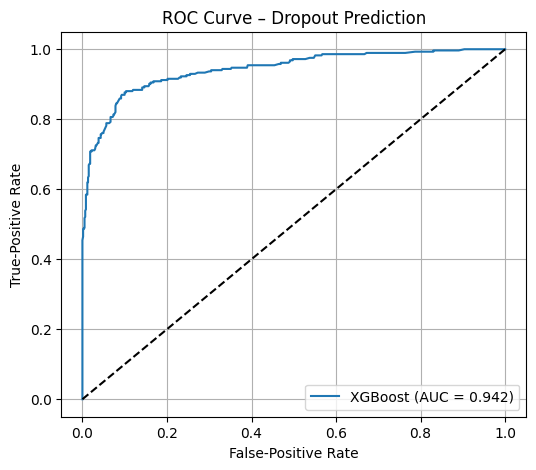

In [31]:
roc_auc = roc_auc_score(y_test, p_test)

fpr, tpr, _ = roc_curve(y_test, p_test)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"XGBoost (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False-Positive Rate")
plt.ylabel("True-Positive Rate")
plt.title("ROC Curve – Dropout Prediction")
plt.legend()
plt.grid(True)
plt.show()